#GAN with RNN as classifier

## Importing Libraries

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


## EDA

In [ ]:
df=pd.read_csv('./creditcard.csv')
df=df.drop('Time',axis=1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

PCA Transformation: The description of the data says that all the features went through a PCA transformation (Except for time and amount).  
Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

There is no null values

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

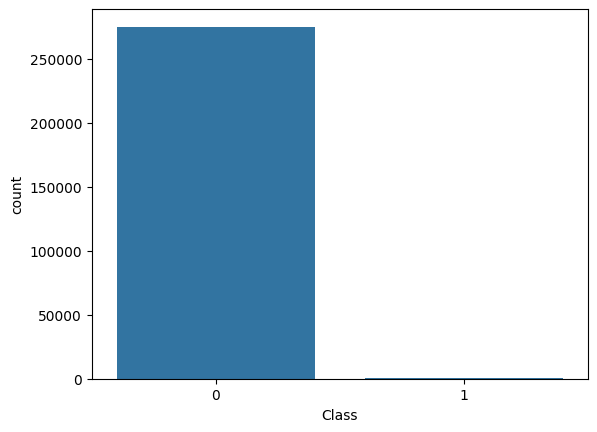

In [ ]:
sns.countplot(data=df,x='Class')

In [ ]:
df.drop('Class',axis=1).skew()

,0
V1,-3.273070
V2,-4.653486
V3,-2.216730
V4,0.681387
V5,-2.458790
V6,1.867576
V7,2.877722
V8,-8.292631
V9,0.550965
V10,1.242165


## Scaling

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


## Splitting the data

we want to test our models on the original testing set not on the testing set created from GAN. The main goal is to fit the model in the generated data, and test it on the original testing set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Testing baseline model with original data

# GAN

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
import tensorflow as tf

class GAN():
    def __init__(self):

        self.latent_dim = 32
        self.out_shape = 29

        self.optimizer = Adam(0.0002, 0.5)


        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['accuracy'],
            run_eagerly=True
        )

        # Build generator
        self.generator = self.build_generator()


    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        output = model(noise)
        return Model(noise, output)

    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Dense(512, input_dim=self.out_shape))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=(self.out_shape,))
        validity = model(img)
        return Model(img, validity)

    def train(self, X_train, y_train, pos_index, neg_index, epochs, batch_size=32, sample_interval=50):
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            idx_pos = np.random.choice(pos_index, 8)
            idx_neg = np.random.choice(neg_index, batch_size - 8)
            idx = np.concatenate([idx_pos, idx_neg])
            real_samples = X_train[idx]
            real_samples, _ = shuffle(real_samples, y_train[idx])

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict(noise)

            if epoch < epochs / 1.5:
                valid_smooth = (valid + 0.1) - (np.random.random(valid.shape) * 0.1)
                fake_smooth = (fake - 0.1) + (np.random.random(fake.shape) * 0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            self.discriminator.trainable = True
            d_real_loss, d_real_acc = self.discriminator.train_on_batch(real_samples, valid_smooth)
            d_fake_loss, d_fake_acc = self.discriminator.train_on_batch(gen_samples, fake_smooth)
            d_loss = [0.5 * (d_real_loss + d_fake_loss), 0.5 * (d_real_acc + d_fake_acc)]

            # ---------------------
            #  Train Generator
            # ---------------------
            # Recreate combined model for training generator with discriminator frozen
            noise = Input(shape=(self.latent_dim,))
            generated = self.generator(noise)
            self.discriminator.trainable = False # Ensure discriminator is frozen
            validity = self.discriminator(generated)
            self.combined = Model(noise, validity)
            self.combined.compile(
                loss='binary_crossentropy',
                optimizer=Adam(0.0002, 0.5), # Recreate optimizer for combined model
                metrics=['accuracy'],
                run_eagerly=True  # Enable eager execution
            )

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss, g_acc = self.combined.train_on_batch(noise, valid)


            if (epoch + 1) % sample_interval == 0:
                print(f"Epoch {epoch + 1}/{epochs} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")



In [ ]:
gan = GAN()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,713 (702.00 KB)

 Trainable params: 179,713 (702.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,293 (731.61 KB)

 Trainable params: 185,501 (724.61 KB)

 Non-trainable params: 1,792 (7.00 KB)

#Training GAN

In [ ]:
y_train = y_train.reshape(-1, 1)
pos_index = np.where(y_train == 1)[0]
neg_index = np.where(y_train == 0)[0]
gan.train(X_train, y_train, pos_index, neg_index, epochs=1000)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━

#Generating new samples

In [ ]:

noise = np.random.normal(0, 1, (250_000, gan.latent_dim))


gen_samples = gan.generator.predict(noise, verbose=0)


In [ ]:

gen_samples = scaler.inverse_transform(gen_samples)
print("Synthetic shape:", gen_samples.shape)



Synthetic shape: (250000, 29)


In [ ]:

gen_df = pd.DataFrame(gen_samples, columns=df.drop('Class', axis=1).columns)
print(gen_df.head())



         V1        V2        V3        V4        V5        V6        V7  \
0  1.297701  0.317588  0.241068 -1.377550 -0.804555 -1.079187  0.487594   
1  1.578573  1.554756 -1.313852  1.301926 -0.501937 -1.076981  0.820113   
2  0.610707  1.337226 -0.989589  1.397404 -0.311002 -0.623031 -0.619967   
3 -1.548679  1.617200  1.532955 -1.424939 -1.246720 -0.323919  1.214420   
4  1.893631  1.611822  1.532774  1.339431 -1.049872  0.987859  1.248252   

         V8        V9       V10  ...       V20       V21       V22       V23  \
0 -0.042994  1.053289 -0.889302  ... -0.335916  0.486787 -0.487847 -0.325186   
1 -1.176766  1.024777 -1.037991  ... -0.268906 -0.603310 -0.113854 -0.514452   
2 -0.771524 -0.679726  1.074227  ... -0.747662 -0.645737 -0.670629  0.490072   
3 -1.141892  0.999975 -1.080558  ...  0.391488  0.699572  0.732115 -0.565320   
4 -0.854973  1.083495 -1.080772  ...  0.769485  0.726041  0.604380 -0.574971   

        V24       V25       V26       V27       V28    Amount  
0 -0

In [ ]:
# Append to your real training set
gen_X_train = np.vstack([X_train, gen_samples])
print("Augmented X shape:", gen_X_train.shape)



Augmented X shape: (470530, 29)


In [ ]:

gen_y = np.ones((250_000, 1), dtype='int32')

y_train = y_train.reshape(-1,1)
gen_y_train = np.vstack([y_train, gen_y])
print("Augmented y shape:", gen_y_train.shape)

Augmented y shape: (470530, 1)


## Testing baseline model with generated data

Model: "rnn_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         4,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,051 (15.82 KB)

 Trainable params: 4,051 (15.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
14704/14704 - 164s - 11ms/step - loss: 0.0179 - pr_auc: 0.9995 - precision: 0.9933 - recall: 0.9956 - roc_auc: 0.9991 - val_loss: 0.0133 - val_pr_auc: 0.0017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4958
Epoch 2/5
14704/14704 - 164s - 11ms/step - loss: 0.0069 - pr_auc: 0.9995 - precision: 0.9999 - recall: 0.9984 - roc_auc: 0.9992 - val_loss: 0.0133 - val_pr_auc: 0.0018 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5038
Epoch 3/5
14704/14704 - 165s - 11ms/step - loss: 0.0068 - pr_auc: 0.9995 - precision: 1.0000 - recall: 0.9984 - roc_auc: 0.9992 - val_loss: 0.0131 - val_pr_auc: 0.0017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4945
Epoch 4/5
14704/14704 - 162s - 11ms/step - loss: 0.0065 - pr_auc: 0.9996 - precision: 1.0000 - recall: 0.9985 - roc_auc: 0.9992 - val_loss: 0.0129 - val_pr_auc: 0.0017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4946
Epoch 5/5
14704/14704 - 170s

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0     0.9983    1.0000    0.9991     55009
           1     0.0000    0.0000    0.0000        95

    accuracy                         0.9983     55104
   macro avg     0.4991    0.5000    0.4996     55104
weighted avg     0.9966    0.9983    0.9974     55104



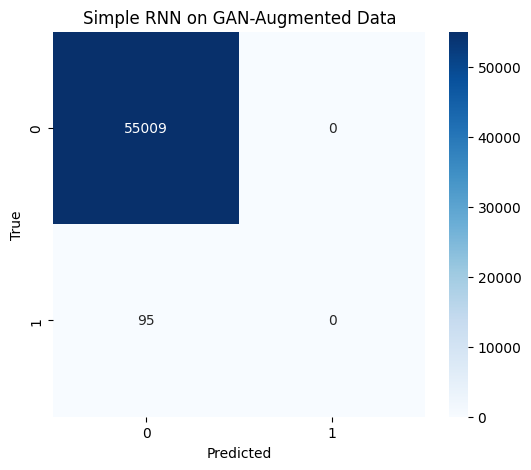

In [ ]:

import tensorflow as tf
tf.config.run_functions_eagerly(False)

SEQ_LEN = 30
BATCH   = 32
EPOCHS  = 5

# Build streaming datasets with Keras’s timeseries_dataset_from_array

y_train_flat = gen_y_train.ravel()  # shape (N_train,)

train_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=gen_X_train,
    targets=y_train_flat,
    sequence_length=SEQ_LEN,
    sampling_rate=1,
    batch_size=BATCH,
    shuffle=True
).prefetch(tf.data.AUTOTUNE)

val_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X_test,
    targets=y_test,
    sequence_length=SEQ_LEN,
    sampling_rate=1,
    batch_size=BATCH,
    shuffle=False
).prefetch(tf.data.AUTOTUNE)

#  Build your SimpleRNN
n_features = gen_X_train.shape[1]
model = tf.keras.Sequential([
    tf.keras.Input(shape=(SEQ_LEN, n_features)),
    tf.keras.layers.SimpleRNN(50, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name='rnn_classifier')

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-4),
    loss='binary_crossentropy',
    metrics=[
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='roc_auc'),
      tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
    ]
)

model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=2
)

y_prob = model.predict(val_ds).ravel()
y_pred = (y_prob > 0.5).astype(int)


y_true = tf.concat([y for x,y in val_ds], axis=0).numpy()

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns

print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Simple RNN on GAN-Augmented Data")
plt.show()


Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355), [Generative adversarial networks-based novel approach for fraud detection for the European Cardholders 2013 dataset](https://doi.org/10.1109/ACCESS.2023.3320072), [ The importance of future information in credit card fraud detection](https://arxiv.org/abs/2204.05265), https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/code

Note- ChatGPT used for understanding results and help with rnn code going out of memory

The Simple RNN with GAN-augmented data performs very poorly on fraud detection despite maintaining very high accuracy on the majority class:

The confusion matrix reveals that the model completely failed to detect fraud cases (all 95 fraud transactions misclassified as legitimate).

Fraud class metrics collapse to precision = 0.0, recall = 0.0, F1-score = 0.0, confirming no learning signal for minority class.

Accuracy remains at 99.83%, but this is misleading due to the extreme class imbalance.

The macro average metrics (precision, recall, F1 ≈ 0.50) further highlight the imbalance issue, as performance is entirely dominated by the majority class.

Overall, GAN + RNN is ineffective for fraud detection. While it perfectly classifies legitimate transactions, it fails to identify any fraudulent cases, making it unsuitable for real-world fraud detection tasks.